Извлечение данных из базы данных...
Данные успешно извлечены и сохранены в файл /arps_d_teach/d_teach_from_db.txt.
Обучение модели...
Лучшие гиперпараметры:
    n_estimators: 12
    use_max_depth: False
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Оценка модели:
MAE: 0.0000
MSE: 0.0000
R2: 0.9323

Выполнение прогнозирования...

Результаты прогнозирования:


,Скважина,D,Накоп за 6 мес,Накоп за 12 мес,Все запасы
0,NewWell-26P,0.000019,13477.027501,27355.243448,3.447773e+06
1,NewWell-27P,0.000022,7634.786034,15492.270414,1.851047e+06
2,NewWell-28P,0.000017,19284.047402,39148.226477,5.083895e+06
3,NewWell-29P,0.000022,8856.351800,17971.033680,2.147214e+06
4,NewWell-30P,0.000022,3880.245224,7873.626087,9.397844e+05
5,NewWell-31P,0.000017,14647.114195,29734.582692,3.854211e+06
6,NewWell-32P,0.000019,12309.260653,24985.452407,3.161137e+06
7,NewWell-33P,0.000017,20507.302138,41633.942031,5.469159e+06
8,NewWell-34P,0.000017,18997.672362,38569.320537,5.072652e+06
9,NewWell-35P,0.000023,8675.689682,17602.315810,2.060183e+06


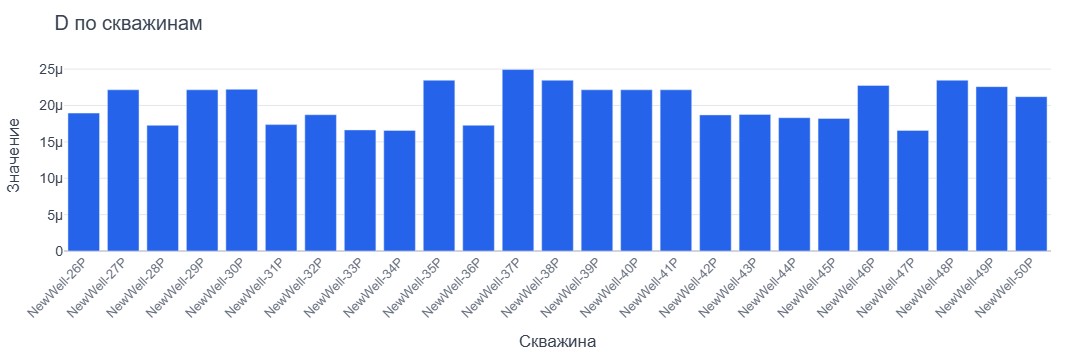

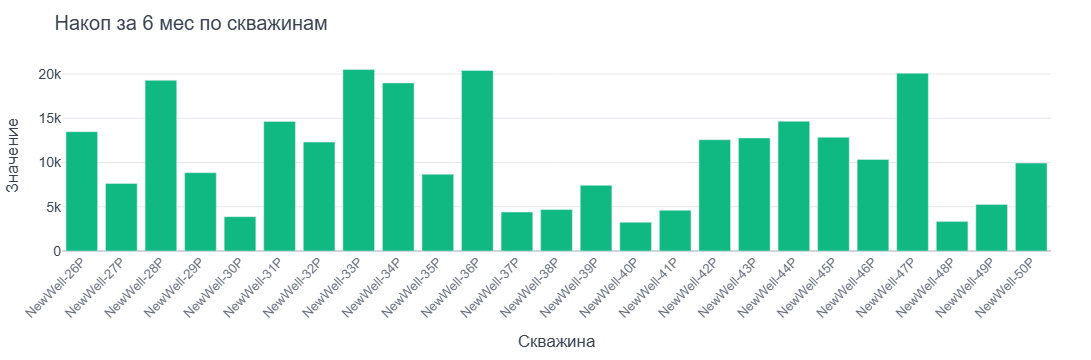

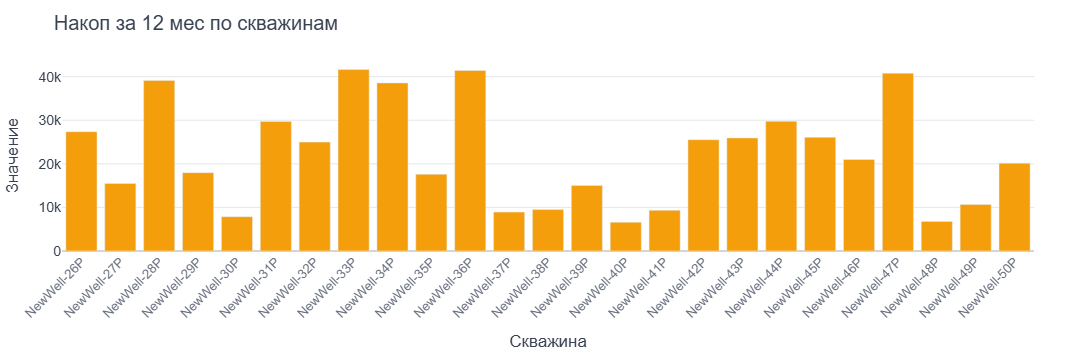

In [1]:
import pandas as pd
import numpy as np
import math
import joblib
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


class DataExtractor:
    def __init__(self, db_config):
        """Инициализация класса для извлечения данных из БД"""
        self.connection = mysql.connector.connect(**db_config)

    def get_data(self):
        """Извлечение данных из БД и формирование DataFrame"""
        cursor = self.connection.cursor(dictionary=True)

        # Получение всех скважин из well_geo_info
        cursor.execute("SELECT well_name FROM well_geo_info")
        wells = cursor.fetchall()

        results = []

        for well in wells:
            well_name = well['well_name']

            # Получение стартового дебита и Lhor (первый ненулевой oil_rate_per_day по дате)
            cursor.execute(f"""
                SELECT oil_rate_per_day, Lhor 
                FROM well_production_data 
                WHERE well_name = %s 
                AND oil_rate_per_day > 0 
                ORDER BY date ASC 
                LIMIT 1
            """, (well_name,))
            start_rate = cursor.fetchone()

            if start_rate is None:
                # Если нет стартового дебита, пропускаем скважину
                continue

            start_oil_rate = start_rate['oil_rate_per_day']
            Lhor = start_rate['Lhor']

            # Получение KH из well_geo_info
            cursor.execute(f"SELECT KH FROM well_geo_info WHERE well_name = %s", (well_name,))
            kh_data = cursor.fetchone()
            KH = kh_data['KH'] if kh_data else None

            # Получение координат текущей скважины
            cursor.execute("""
                SELECT wellhead_X, wellhead_Y 
                FROM wells_coordinate 
                WHERE well_name = %s
            """, (well_name,))
            current_well_coords = cursor.fetchone()
            if current_well_coords is None:
                continue
            current_x, current_y = current_well_coords['wellhead_X'], current_well_coords['wellhead_Y']

            # Расстояние до ближайшей скважины с ненулевой закачкой (injwat_rate_per_day > 0)
            cursor.execute("""
                SELECT wc.well_name, wc.wellhead_X, wc.wellhead_Y
                FROM wells_coordinate wc
                JOIN (
                    SELECT DISTINCT well_name
                    FROM well_production_data 
                    WHERE injwat_rate_per_day > 0
                ) wpd ON wc.well_name = wpd.well_name
                WHERE wc.well_name != %s
            """, (well_name,))
            injection_wells = cursor.fetchall()

            min_injection_distance = float('inf')
            for injection_well in injection_wells:
                dx = current_x - injection_well['wellhead_X']
                dy = current_y - injection_well['wellhead_Y']
                distance = np.sqrt(dx*dx + dy*dy)
                if distance < min_injection_distance:
                    min_injection_distance = distance
            # Если таких скважин нет, ставим None
            if min_injection_distance == float('inf'):
                min_injection_distance = None

            # Расстояние до ближайшей скважины с ненулевой добычей (oil_rate_per_day > 0)
            cursor.execute("""
                SELECT wc.well_name, wc.wellhead_X, wc.wellhead_Y
                FROM wells_coordinate wc
                JOIN (
                    SELECT DISTINCT well_name
                    FROM well_production_data 
                    WHERE oil_rate_per_day > 0
                ) wpd ON wc.well_name = wpd.well_name
                WHERE wc.well_name != %s
            """, (well_name,))
            production_wells = cursor.fetchall()

            min_production_distance = float('inf')
            for prod_well in production_wells:
                dx = current_x - prod_well['wellhead_X']
                dy = current_y - prod_well['wellhead_Y']
                distance = np.sqrt(dx*dx + dy*dy)
                if distance < min_production_distance:
                    min_production_distance = distance
            if min_production_distance == float('inf'):
                min_production_distance = None

            # Получение суммарной добычи нефти для скважины (сумма oil_rate_per_day)
            cursor.execute("""
                SELECT SUM(oil_rate_per_day) AS total_oil 
                FROM well_production_data 
                WHERE well_name = %s
            """, (well_name,))
            total_oil_data = cursor.fetchone()
            total_oil = total_oil_data['total_oil'] if total_oil_data and total_oil_data['total_oil'] is not None else 0

            # Получение последнего ненулевого дебита (oil_rate_per_day > 0, отсортирован по дате DESC)
            cursor.execute("""
                SELECT oil_rate_per_day 
                FROM well_production_data 
                WHERE well_name = %s 
                AND oil_rate_per_day > 0 
                ORDER BY date DESC 
                LIMIT 1
            """, (well_name,))
            last_rate_data = cursor.fetchone()
            last_oil_rate = last_rate_data['oil_rate_per_day'] if last_rate_data else 0

            # Расчет D с защитой от деления на 0
            D = (start_oil_rate / last_oil_rate) / total_oil if last_oil_rate > 0 and total_oil > 0 else 0

            results.append({
                'Стартовый дебит': start_oil_rate,
                'KH': KH,
                'Lгор': Lhor,
                'Расстояние до ближайщей скважины с ненулевой закачкой': min_injection_distance,
                'Расстояние до ближайщей скважины с ненулевой добычей': min_production_distance,
                'D': D,
                'Скважина': well_name
            })

        cursor.close()
        return pd.DataFrame(results)

    def close(self):
        """Закрытие соединения с БД"""
        self.connection.close()


class OilProductionForecaster:
    def __init__(self):
        """Инициализация класса для прогнозирования добычи нефти"""
        self.scaler = StandardScaler()  # Скалер для нормализации данных
        self.model = None  # Место для хранения обученной модели
        self.best_params = None  # Лучшие параметры модели после оптимизации

    def load_data(self, train_path: str, target_column: str = 'D') -> tuple:
        """
        Загрузка и подготовка тренировочных данных
        :param train_path: путь к файлу с данными
        :param target_column: название целевой переменной
        :return: кортеж (признаки, целевая переменная, список скважин)
        """
        df = pd.read_csv(train_path, delimiter=';')
        wells = df['Скважина'].tolist()  # Список названий скважин
        X = df.drop(columns=['Скважина'])  # Признаки (все кроме названия скважины)
        y = df[target_column]  # Целевая переменная (параметр D)
        return X, y, wells

    def preprocess_data(self, X_train, X_test, y_train, y_test) -> tuple:
        """
        Масштабирование признаков и разделение данных
        :return: кортеж с масштабированными данными
        """
        X_train_scaled = self.scaler.fit_transform(X_train)  # Обучение скалера и трансформация тренировочных данных
        X_test_scaled = self.scaler.transform(X_test)  # Трансформация тестовых данных
        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, X_train, y_train, n_trials=50) -> None:
        """
        Обучение модели Random Forest с оптимизацией гиперпараметров
        :param X_train: тренировочные признаки
        :param y_train: тренировочные целевые значения
        :param n_trials: количество итераций оптимизации
        """
        # Создание объекта для оптимизации гиперпараметров
        study = optuna.create_study(direction='minimize')

        # Запуск оптимизации
        study.optimize(lambda trial: self._objective(trial, X_train, y_train), n_trials=n_trials)

        # Сохранение лучших параметров
        self.best_params = study.best_params
        print("Лучшие гиперпараметры:")
        for key, value in self.best_params.items():
            print(f"    {key}: {value}")

        # Создание и обучение модели с лучшими параметрами
        self.model = RandomForestRegressor(
            n_estimators=self.best_params['n_estimators'],
            max_depth=self.best_params.get('max_depth', None),
            min_samples_split=self.best_params['min_samples_split'],
            min_samples_leaf=self.best_params['min_samples_leaf'],
            max_features=self.best_params['max_features'],
            random_state=42
        )
        self.model.fit(X_train, y_train)

    def _objective(self, trial, X_train, y_train) -> float:
        """
        Целевая функция для оптимизации гиперпараметров
        :return: значение метрики MAE для текущего набора параметров
        """
        # Подбор гиперпараметров
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 50),
            'max_depth': trial.suggest_int('max_depth', 3, 20) if trial.suggest_categorical('use_max_depth', [True, False]) else None,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }

        # Создание и обучение временной модели
        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, y_train)

        # Расчет метрики качества
        y_pred = model.predict(X_train)
        return mean_absolute_error(y_train, y_pred)

    def evaluate_model(self, X_test, y_test) -> dict:
        """
        Оценка качества модели на тестовых данных
        :return: словарь с метриками качества
        """
        y_pred = self.model.predict(X_test)
        return {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }

    def save_model(self, path: str) -> None:
        """Сохранение обученной модели и скалера в файл"""
        joblib.dump((self.model, self.scaler), path)

    def load_model(self, path: str) -> None:
        """Загрузка обученной модели и скалера из файла"""
        self.model, self.scaler = joblib.load(path)

    def predict_production(self, input_path: str) -> pd.DataFrame:
        """
        Прогнозирование добычи для новых скважин
        :param input_path: путь к файлу с данными новых скважин
        :return: DataFrame с результатами прогнозирования
        """
        # Загрузка и подготовка новых данных
        new_data = pd.read_csv(input_path, sep=';')
        wells = new_data['Скважина'].tolist()  # Список скважин
        qoil = new_data['Стартовый дебит'].tolist()  # Стартовые дебиты
        X_new = new_data.drop(columns=['Скважина'])  # Признаки

        # Масштабирование и предсказание
        X_new_scaled = self.scaler.transform(X_new)
        d_pred = self.model.predict(X_new_scaled)  # Предсказанные значения D

        # Расчет накопленной добычи
        results = []
        for q, d in zip(qoil, d_pred):
            results.append({
                'D': d,
                'Накоп за 6 мес': self._calculate_cumulative(q, d, 180),  # 180 дней = 6 месяцев
                'Накоп за 12 мес': self._calculate_cumulative(q, d, 366),  # 366 дней = 12 месяцев
                'Все запасы': self._calculate_cumulative(q, d, 73332)  # 73332 дня ≈ 20 лет
            })

        # Создание итогового DataFrame
        return pd.DataFrame({
            'Скважина': wells,
            **{k: [r[k] for r in results] for k in results[0]}
        })

    def _calculate_cumulative(self, q: float, d: float, days: int) -> float:
        """
        Расчет накопленной добычи по формуле Арпса
        :param q: начальный дебит
        :param d: параметр D
        :param days: период в днях
        :return: накопленная добыча
        """
        return (q / abs(d)) * math.log(1 + abs(d) * days)


def main():
    """Основная функция выполнения скрипта"""
    
    db_config = {
        'user': 'root',
        'password': 'Qsc_028ud',
        'host': 'mysql',
        'database': 'oil_production_db',
        'auth_plugin': 'mysql_native_password'  # Add this line if using mysql-connector-python
    }

    # Извлечение и подготовка данных из базы
    print("Извлечение данных из базы данных...")
    extractor = DataExtractor(db_config)
    data = extractor.get_data()
    extractor.close()

    # Сохранение подготовленных данных в файл формата для обучения
    data_file = '/arps_d_teach/d_teach_from_db.txt'
    data.to_csv(data_file, sep=';', index=False)
    print(f"Данные успешно извлечены и сохранены в файл {data_file}.")

    # Инициализация прогнозировщика
    forecaster = OilProductionForecaster()

    # Загрузка данных и разделение на обучающую и тестовую выборки
    X, y, _ = forecaster.load_data(data_file)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled, y_train, y_test = forecaster.preprocess_data(X_train, X_test, y_train, y_test)

    # Обучение модели с оптимизацией гиперпараметров
    print("Обучение модели...")
    forecaster.train_model(X_train_scaled, y_train, n_trials=50)
    forecaster.save_model('trained_random_forest_model_D.conf.pkl')

    # Оценка качества модели
    metrics = forecaster.evaluate_model(X_test_scaled, y_test)
    print(f"\nОценка модели:")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"R2: {metrics['R2']:.4f}")

    # Прогнозирование значений на основе новых данных (можно использовать другой файл с новыми скважинами)
    print("\nВыполнение прогнозирования...")
    forecaster.load_model('trained_random_forest_model_D.conf.pkl')
    forecast_file = '/arps_d_teach/forecast_data.txt'  # Здесь должны быть данные для прогноза в аналогичном формате
    predictions = forecaster.predict_production(forecast_file)

    # Вывод результатов прогноза
    print("\nРезультаты прогнозирования:")
    # таблица
    display(predictions)
    import plotly.graph_objects as go
    
    # Графики Plot
    fig_d = go.Figure(data=go.Bar(
        x=predictions['Скважина'],
        y=predictions['D'],
        marker_color='#2563EB',
        hovertemplate='Скважина %{x}<br>D: %{y:.8f}<extra></extra>'
    ))
    
    fig_d.update_layout(
        title='D по скважинам',
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family='Poppins, sans-serif', size=14, color='#374151'),
        margin=dict(t=60, b=100, l=60, r=40),
        xaxis=dict(title='Скважина', tickangle=-45, tickfont=dict(size=13, color='#6B7280')),
        yaxis=dict(title='Значение', zeroline=True, zerolinecolor='#D1D5DB', zerolinewidth=2, gridcolor='#E5E7EB'),
    )
    
    # Graph for Накоп за 6 мес
    fig_6m = go.Figure(data=go.Bar(
        x=predictions['Скважина'],
        y=predictions['Накоп за 6 мес'],
        marker_color='#10B981',
        hovertemplate='Скважина %{x}<br>Накоп за 6 мес: %{y:.0f}<extra></extra>'
    ))
    
    fig_6m.update_layout(
        title='Накоп за 6 мес по скважинам',
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family='Poppins, sans-serif', size=14, color='#374151'),
        margin=dict(t=60, b=100, l=60, r=40),
        xaxis=dict(title='Скважина', tickangle=-45, tickfont=dict(size=13, color='#6B7280')),
        yaxis=dict(title='Значение', zeroline=True, zerolinecolor='#D1D5DB', zerolinewidth=2, gridcolor='#E5E7EB'),
    )
    
    # Graph for Накоп за 12 мес
    fig_12m = go.Figure(data=go.Bar(
        x=predictions['Скважина'],
        y=predictions['Накоп за 12 мес'],
        marker_color='#F59E0B',
        hovertemplate='Скважина %{x}<br>Накоп за 12 мес: %{y:.0f}<extra></extra>'
    ))
    
    fig_12m.update_layout(
        title='Накоп за 12 мес по скважинам',
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family='Poppins, sans-serif', size=14, color='#374151'),
        margin=dict(t=60, b=100, l=60, r=40),
        xaxis=dict(title='Скважина', tickangle=-45, tickfont=dict(size=13, color='#6B7280')),
        yaxis=dict(title='Значение', zeroline=True, zerolinecolor='#D1D5DB', zerolinewidth=2, gridcolor='#E5E7EB'),
    )
    
    # Show the figures
    fig_d.show()
    fig_6m.show()
    fig_12m.show()

if __name__ == "__main__":
    main()
    

In [2]:
display(predictions)

NameError: name 'predictions' is not defined